# Programming Lab 5 - Deep Learning

***
##### CS 434 - Data Mining and Machine Learning
##### Oregon State University-Cascades
***

In [1]:
name = "Matthew O'Malley-Nichols"   # <== fill in
assert name != ""
print(name+'\'s Lab 5 submission')

Matthew O'Malley-Nichols's Lab 5 submission


***
# Load packages
***

Any additional packages you need for this lab should be added here.

**DO NOT** import packages anywhere else!

In [2]:
# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.metrics import Recall, AUC, BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping
# numpy/cupy/pandas
import numpy as np
import cupy as cp # GPU numpy/scipy
import pandas as pd
# Ipython/Display
import IPython
from IPython.display import clear_output
from tqdm import tqdm
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Scipy loading
from scipy.io import loadmat
from scipy.stats import skew, kurtosis, entropy, variation
from scipy.signal import welch
import os
# MNE for EEG data
import mne
# partial functions
from functools import partial
# Support Vector Classifier 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
clear_output()

In [3]:
"""Setup CUPY for GPU use with MNE"""
!MNE_USE_CUDA=true python -c "import mne; mne.cuda.init_cuda(verbose=True)"
mne.utils.set_config('MNE_USE_CUDA', 'true')

Now using CUDA device 0
Enabling CUDA with 3.72 GB available memory


In [ ]:
tf.config.list_physical_devices()
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
%load_ext memory_profiler

***
#  Objective
***

This is an open-ended lab in which you will explore TensorFlow on a problem of your choosing.

1.  Pick a dataset
2.  Build a tensorflow deep learning model
3.  Train and test your model
4.  Analyze your results
5.  Write a report

> **Submission**: run the entire notebook before submission.  I will **not** re-run it to grade.

***
# Data
***

You will find and choose a dataset $^1$ suitable for deep-learning.  Explore the [TensorFlow datasets](https://www.tensorflow.org/datasets/catalog/overview).

If you wish, you may choose a dataset from a different source (for ideas, start [here](https://en.wikipedia.org/wiki/List_of_datasets_for_machine-learning_research), [here](http://deeplearning.net/datasets/), or [here](https://gym.openai.com/)).

$^1$ You may **not** use MNIST, CelebA, or MIT datasets that we used in the Activities.

##### Protips

A good strategy is to read several related articles on a topic (e.g., image classification with CNN) and **interpolate** an approach that combines aspects from each source. Then, apply this approach on on an entirely **different dataset** not used in the articles.
> Be sure to cite any sources that you draw inspiration from.

> You may not directly copy someone else's code - plagiarism detection is very easy. All of the usual academic honestly policies apply.

> * Choose something that interests you.  It makes the lab more fun.
>
> * Determine your problem type
>   * e.g., classification, regression, auto-regression, reinforcement
>
> * Split to train/validation/test and use each appropriately.
>
> * Some datasets are very large. You do not have to use ALL of it (i.e. subsample).
>   * size is problem dependent, but look to Activies 18-20 for guidance
>
>
> * Develop your approach on a (very?) small subset of data (for speed) and scale up after you finish your empirical design.
>
> * Look at our Activities and [Towards Data Science](https://towardsdatascience.com/) articles for ideas and inspiration.

## Dataset Selection

### Explore Dataset

In [6]:
interictal_sample = loadmat("/home/matthewo/Documents/Projects/lab5//Patient_1_interictal_segment_0002.mat")
preictal_sample = loadmat("/home/matthewo/Documents/Projects/lab5//Patient_1_preictal_segment_0001.mat")

In [7]:
def data_desc_from_sample(sample):
  data_segment = list(dict(filter(lambda x: "_segment_" in x[0], sample.items())).values())[0][0][0]
  # Length, freq, channels, sequence
  desc = [data_segment[1][0][0], data_segment[2][0][0], data_segment[3][0], data_segment[4][0][0]]
  data = data_segment[0]
  return data, desc

i_sample_data, i_sample_desc = data_desc_from_sample(interictal_sample)
p_sample_data, p_sample_desc = data_desc_from_sample(preictal_sample)
print(i_sample_desc)
print(f"(Rows, Columns): {i_sample_data.shape}")
print(i_sample_data)

[600, 5000, array([array(['LD_1'], dtype='<U4'), array(['LD_3'], dtype='<U4'),
       array(['LD_4'], dtype='<U4'), array(['LD_5'], dtype='<U4'),
       array(['LD_6'], dtype='<U4'), array(['LD_7'], dtype='<U4'),
       array(['LD_8'], dtype='<U4'), array(['RD_1'], dtype='<U4'),
       array(['RD_2'], dtype='<U4'), array(['RD_3'], dtype='<U4'),
       array(['RD_4'], dtype='<U4'), array(['RD_5'], dtype='<U4'),
       array(['RD_6'], dtype='<U4'), array(['RD_7'], dtype='<U4'),
       array(['RD_8'], dtype='<U4')], dtype=object), 2]
(Rows, Columns): (15, 3000000)
[[ -220  -219  -218 ...   158   158   158]
 [ -297  -297  -297 ...     0     1     2]
 [ -253  -253  -253 ...    -1     0    -1]
 ...
 [ -578  -578  -578 ...   382   382   380]
 [-1074 -1074 -1073 ...   947   947   945]
 [ -651  -653  -655 ...   358   357   355]]


### Load dataset

In [8]:
fp = "/home/matthewo/Documents/Projects/lab5//"
filepaths = [
    fp + "Patient_1_interictal_segment_0001.mat",
    fp + "Patient_1_preictal_segment_0001.mat",
]

In [9]:
# This data structure was abandoned due to performance issues with epochs
class EpochWrapper():
  def __init__(self, filepaths):
    self.freq = 5000
    self.length = 0
    self.epochs = None
    self.channel_types = ["eeg" for i in range(15)]
    self.event_ids = {"interictal":0,
                      "preictal":1}
    for f in filepaths:
      self.add_file_to_epochs(f)

  def data_desc_from_sample(self, filepath):
    sample = loadmat(file_name=filepath)
    data_segment = list(dict(filter(lambda x: "_segment_" in x[0], sample.items())).values())[0][0][0]
    # Length, freq, channels, sequence
    channel_array = list(np.concatenate([arr.flatten() for arr in data_segment[3][0]]))
    desc = [data_segment[1][0][0], data_segment[2][0][0], channel_array, data_segment[4][0][0]]
    data = data_segment[0]
    return data, desc

  def add_file_to_epochs(self, filepath):
    data, desc = self.data_desc_from_sample(filepath)
    print(data.shape)
    mne_info = mne.create_info(desc[2], desc[1], self.channel_types)
    if "_interictal_" in filepath:
      event_type, event_id = "interictal", 0
    if "_preictal_" in filepath:
      event_type, event_id = "preictal", 1
    if desc[1] == self.freq:
      raw_data = mne.io.RawArray(data, mne_info)
      events = mne.make_fixed_length_events(raw_data, id=event_id, duration=6)
      epoch = mne.Epochs(raw=raw_data,
                         events=events,
                         event_id={event_type:event_id},
                         tmin=0.0, tmax=6.0,
                         baseline=None)
      del raw_data; del events
      epoch.drop_bad()
      self.length += len(epoch.events)
      if self.epochs:
        self.epochs = mne.concatenate_epochs([self.epochs, epoch])
        epoch.drop_bad()
      else:
        self.epochs = epoch
    else:
      print(f"Frequency incorrect")

In [10]:
epochs_wrapper = EpochWrapper(filepaths=filepaths)

(15, 3000000)
Creating RawArray with float64 data, n_channels=15, n_times=3000000
    Range : 0 ... 2999999 =      0.000 ...   600.000 secs
Ready.
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 30001 original time points ...
1 bad epochs dropped
(15, 3000000)
Creating RawArray with float64 data, n_channels=15, n_times=3000000
    Range : 0 ... 2999999 =      0.000 ...   600.000 secs
Ready.
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 30001 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 99 events and 30001 original time points ...
Using data from preloaded Raw for 99 events and 30001 original time points ...
Not setting metadata
198 matching events found
No baseline correction applied


In [11]:
print(epochs_wrapper.epochs.info)

<Info | 7 non-empty values
 bads: []
 ch_names: LD_1, LD_3, LD_4, LD_5, LD_6, LD_7, LD_8, RD_1, RD_2, RD_3, ...
 chs: 15 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 2500.0 Hz
 meas_date: unspecified
 nchan: 15
 projs: []
 sfreq: 5000.0 Hz
>


Using matplotlib as 2D backend.


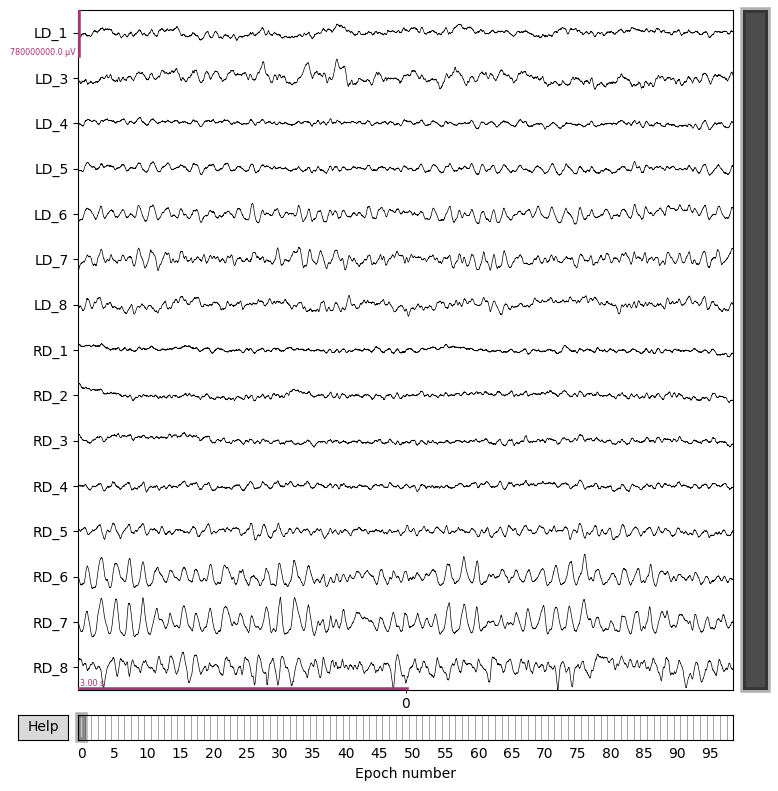

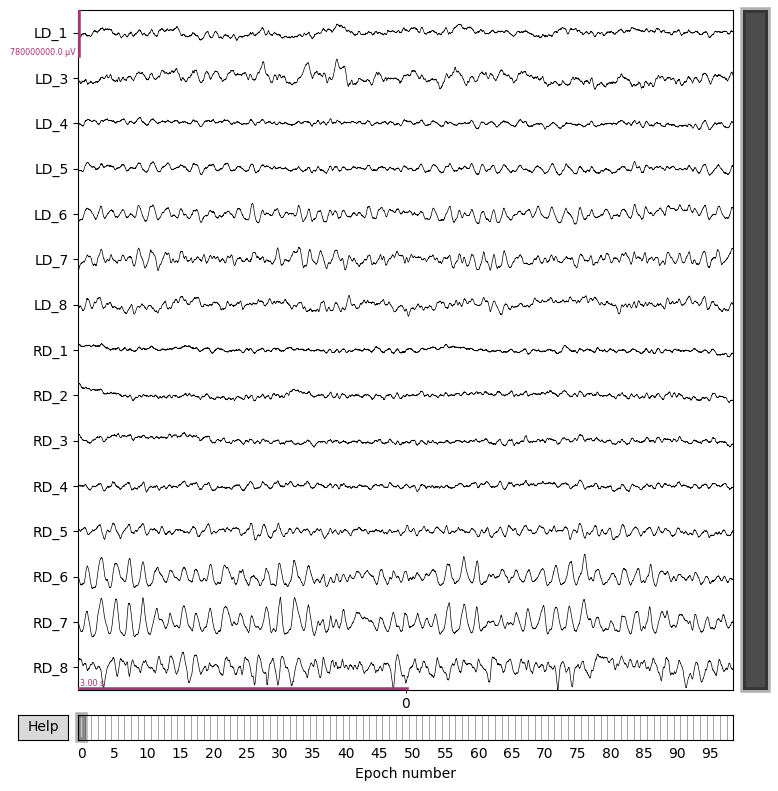

In [12]:
epochs_wrapper.epochs["interictal"].plot(scalings="auto", n_epochs=1)

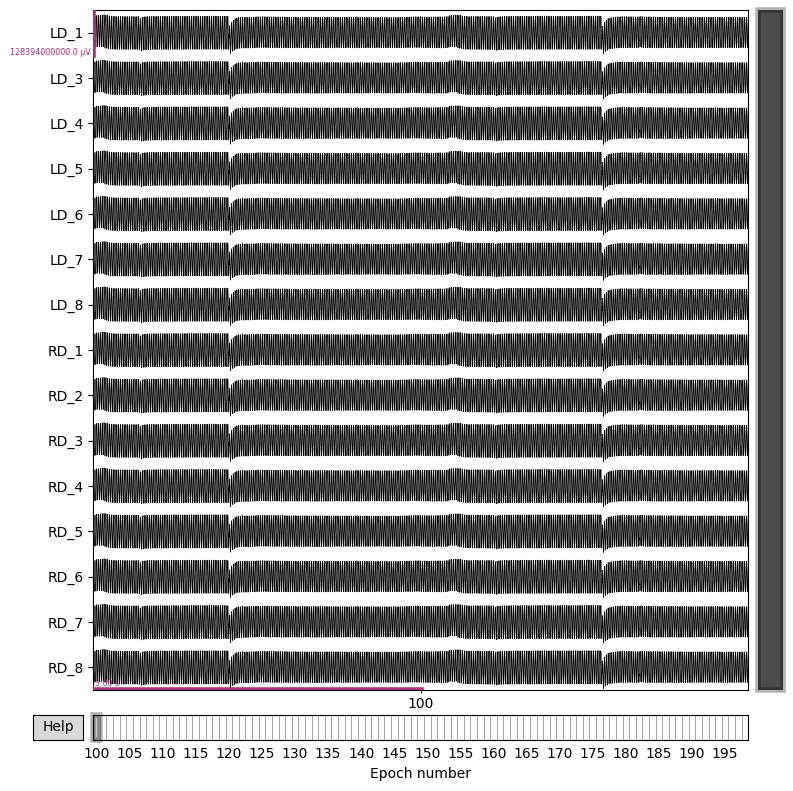

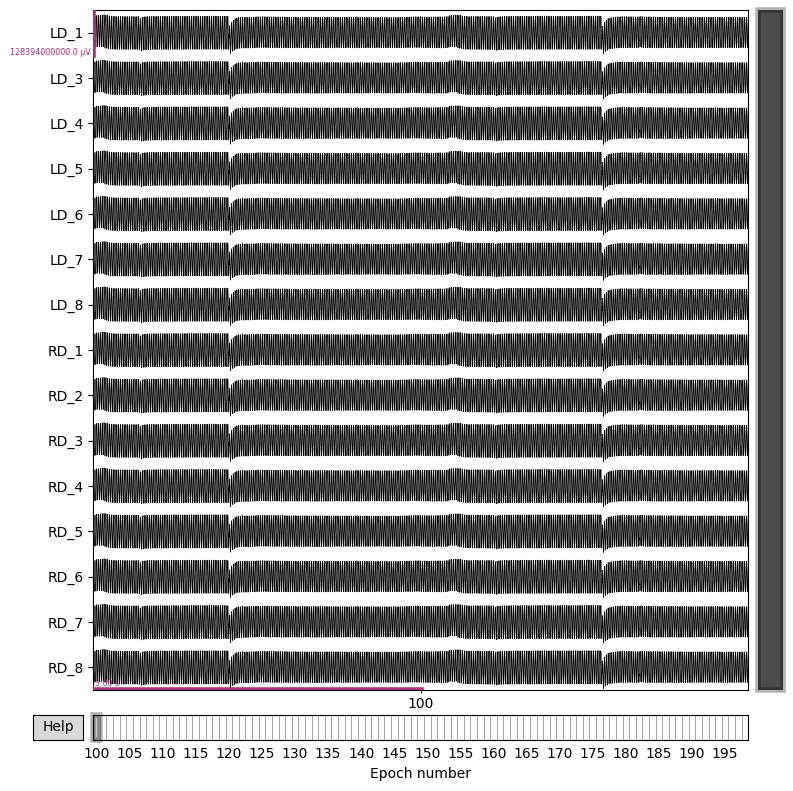

In [13]:
epochs_wrapper.epochs["preictal"].plot(scalings="auto", n_epochs=1) # 6 seconds

In [14]:
del epochs_wrapper

#### Wrapper For RawArrays

In [15]:
%%memit
# Make a balanced dataset
filepaths += [fp + f"Patient_1_interictal_segment_{i:04d}.mat" for i in range(2, 19)]
filepaths += [fp + f"Patient_1_preictal_segment_{i:04d}.mat" for i in range(2, 19)]

peak memory: 1754.32 MiB, increment: 0.11 MiB


In [16]:
class RawWrapper():
  def __init__(self, filepaths):
    self.sfreq = 5000
    self.length = 0
    self.raws = []
    self.channel_types = ["eeg" for i in range(15)]
    self.event_ids = []
    for f in filepaths:
      self.add_file_to_raws(f)

  def data_desc_from_sample(self, filepath):
    sample = loadmat(file_name=filepath)
    data_segment = list(dict(filter(lambda x: "_segment_" in x[0], sample.items())).values())[0][0][0]
    # Length, freq, channels, sequence
    channel_array = list(np.concatenate([arr.flatten() for arr in data_segment[3][0]]))
    desc = [data_segment[1][0][0], data_segment[2][0][0], channel_array, data_segment[4][0][0]]
    data = data_segment[0]
    del sample, data_segment, channel_array
    return data, desc

  def add_file_to_raws(self, filepath):
    data, desc = self.data_desc_from_sample(filepath)
    print(data.shape)
    mne_info = mne.create_info(desc[2], desc[1], self.channel_types)
    if "_interictal_" in filepath:
      event_type, event_id = "interictal", 0
    elif "_preictal_" in filepath:
      event_type, event_id = "preictal", 1
    if desc[1] == self.sfreq:
      raw_data = mne.io.RawArray(data, mne_info)
      self.raws.append(raw_data)
      self.event_ids.append(event_id)
    del data, desc

  def normalize_every_six_seconds(self): # This method crashes colab -> It loads too much data at once
    for raw in self.raws:
      six_seconds = int(raw.info["sfreq"] * 6)
      for start in range(0, raw.get_data().shape[1], six_seconds):
        end = start + six_seconds
        print(len(raw._data[start:end]))
        min_val = np.min(raw._data[start:end])
        max_val = np.max(raw._data[start:end])
        raw._data[start:end] = (raw._data[start:end] - min_val) / (max_val - min_val)

  def filter(self, l_freq, h_freq=None):
    # Highpass/lowpass the data 
    for raw in self.raws:
        raw.filter(l_freq=l_freq, h_freq=h_freq, n_jobs="cuda")
    
  def filter_by_window(self, l_freq, h_freq=None):
    # Attempt to filter by 6 second window.
    # Discarded due to filter length being too short for transition bands ->
      # Range between the range of passed frequencies and the range of blocked frequencies
    for raw in self.raws:
      sfreq = int(raw.info["sfreq"])
      window = int(sfreq * 6) # 6 seconds
      for s_i in range(0, len(raw.times), window):
          e_i = s_i + window
          data, time = raw[:, s_i:e_i]
          raw[:, s_i:e_i] = mne.filter.filter_data(data=data, sfreq=sfreq, filter_length=5000,
                                                   l_freq=l_freq, h_freq=h_freq, n_jobs="cuda")

  def remove_line_noise(self, freqs):
    # Old method which attempted to remove power line noise from data samples
    for raw in self.raws:
      raw.notch_filter(freqs=freqs, n_jobs="cuda")

  def resample(self, sfreq):
      # Downsample the eeg data to 
      scaling_factor = int(sfreq / self.sfreq)
      for raw in self.raws:
          raw.resample(sfreq=sfreq, n_jobs="cuda")
      self.sfreq = sfreq
      self.length = self.length * scaling_factor
  
  def set_eeg_reference(self):
      # CAR: Subtract average of all EEG channels from each individual EEG channel
      for raw in self.raws:
          raw.set_eeg_reference(ref_channels="average")

In [17]:
%%memit
raw_wrapper = RawWrapper(filepaths=filepaths)
clear_output()

peak memory: 11410.96 MiB, increment: 9656.45 MiB


### Pre-process dataset

Before we begin doing any preprocessing, lets start by looking at some sample EEG data. We will computer the Power Spectrum Density in order to find artifacts in the frequency domain.

Effective window size : 0.410 (s)


/tmp/ipykernel_166439/1157259325.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_wrapper.raws[1].compute_psd().plot()
/usr/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


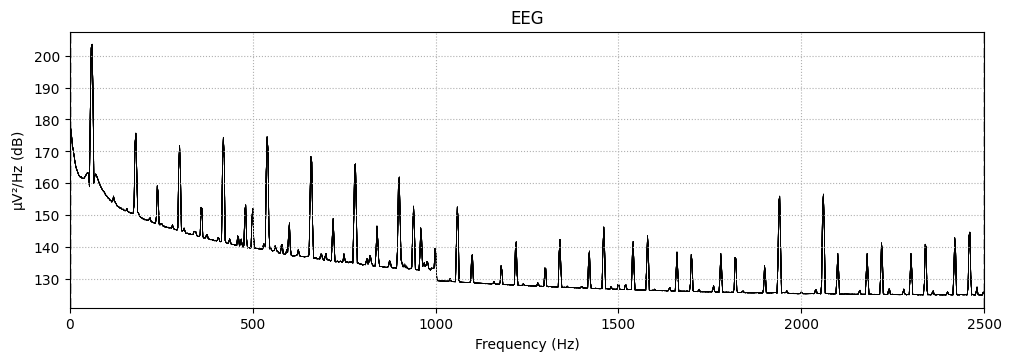

In [18]:
#raw_wrapper.raws[0].compute_psd().plot()
raw_wrapper.raws[1].compute_psd().plot()
#raw_wrapper.raws[2].compute_psd().plot()

#### Filter and Resample Dataset
Looking at the frequency data for sample 1, we can see a vast difference between it and the other samples. Sample 1 has frequency spikes at the harmonics of 60hz. This is likely caused by interference from power lines, as North American power lines run at 60Hz. Furthermore, powerline interference is a known phenomenon in EEG analysis.

In order to improve our computation speeds and prevent overfitting, we will be downsampling our data from 5000Hz to 100Hz. Before we downsample our data, we must run a lowpass filter on the Nyquist frequency of 100Hz in order to prevent aliasing. In addition, we will run a highpass filter at 0.1Hz to remove slow drifts which may lead to our model underfitting.

In [19]:
%%memit
raw_wrapper.filter(l_freq=0.1, h_freq=50)
clear_output()

peak memory: 10970.08 MiB, increment: 484.10 MiB


In [20]:
%%memit
raw_wrapper.resample(sfreq=100)
clear_output()

peak memory: 11527.27 MiB, increment: 5287.98 MiB


Effective window size : 20.480 (s)


/tmp/ipykernel_166439/1157259325.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_wrapper.raws[1].compute_psd().plot()
/usr/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


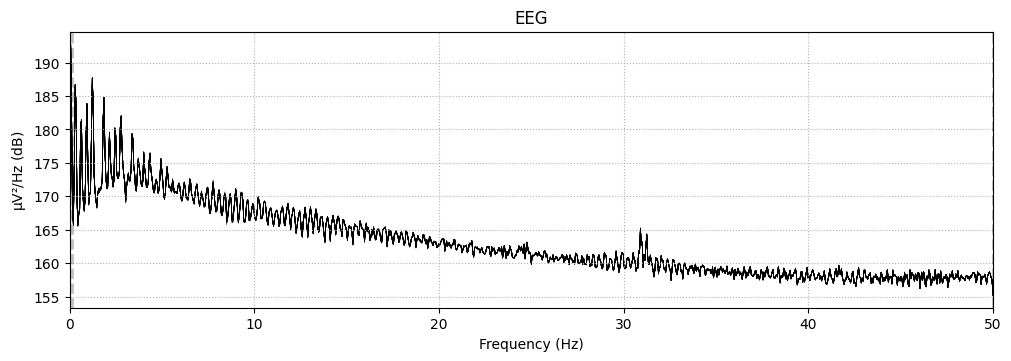

In [21]:
#raw_wrapper.raws[0].compute_psd().plot()
raw_wrapper.raws[1].compute_psd().plot()
#raw_wrapper.raws[2].compute_psd().plot()

#### Set EEG Reference
After resampling our data, we already see less noise in our signal. Next, we will reference our EEG signals using the Common Average Reference (CAR). With CAR, we will subtract the mean potential of each channel from each channel, therefore averaging our channels' errors.$^6$

In [22]:
raw_wrapper.set_eeg_reference()
clear_output()

Effective window size : 20.480 (s)


/tmp/ipykernel_166439/1157259325.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_wrapper.raws[1].compute_psd().plot()
/usr/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


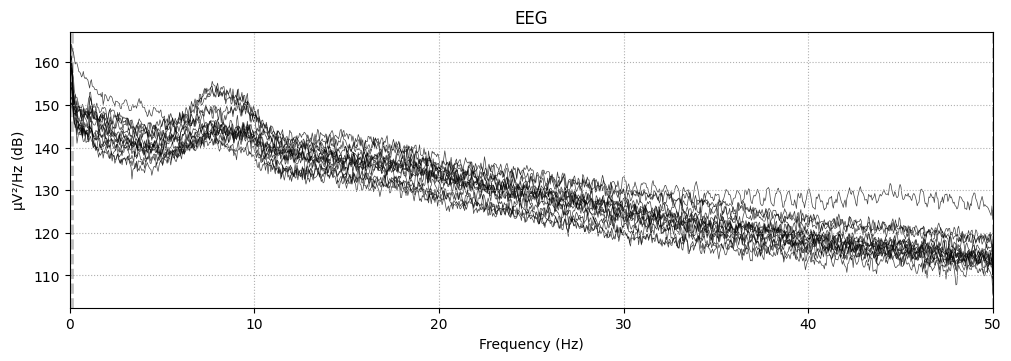

In [23]:
#raw_wrapper.raws[0].compute_psd().plot()
raw_wrapper.raws[1].compute_psd().plot()
#raw_wrapper.raws[2].compute_psd().plot()

#### ICA
After referencing our channels, we can finally see a difference between the channels. The power of the signals fluctuate less, suggesting that noise was removed.

We will be testing ICA on the first sample, though we will not use it as we believe we have already removed artifacts. Furthermore, we will be keeping all 15 channels in order to preserve our results' readability.

In [24]:
ica = mne.preprocessing.ICA(n_components=0.99, random_state=1) 
ica.fit(raw_wrapper.raws[0])

Fitting ICA to data using 15 channels (please be patient, this may take a while)
Selecting by explained variance: 13 components
Fitting ICA took 3.8s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,24 iterations on raw data (60000 samples)
ICA components,13
Available PCA components,15
Channel types,eeg
ICA components marked for exclusion,—


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 0 ICA components
    Projecting back using 15 PCA components


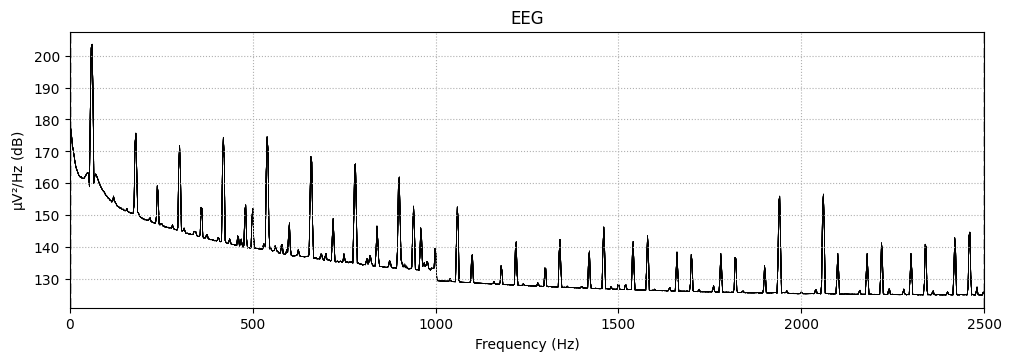

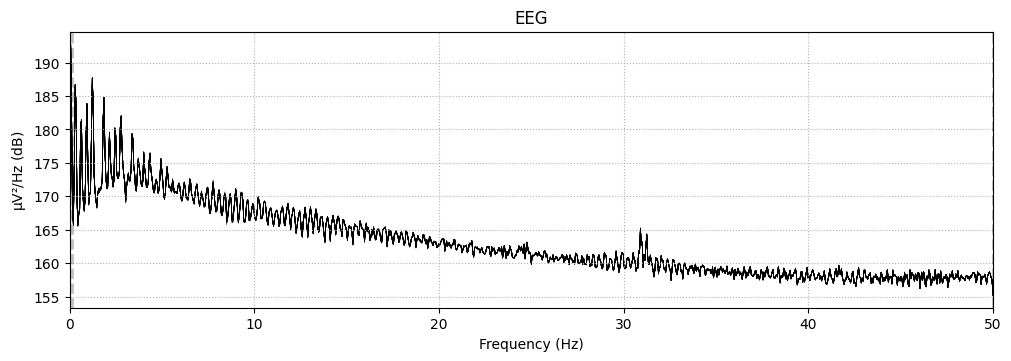

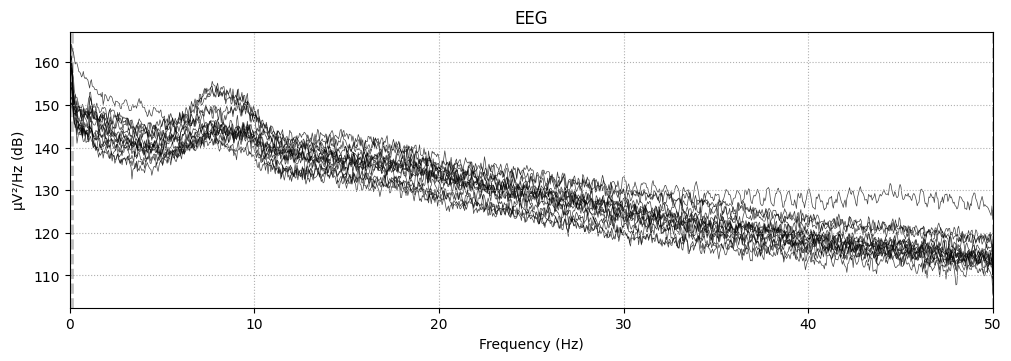

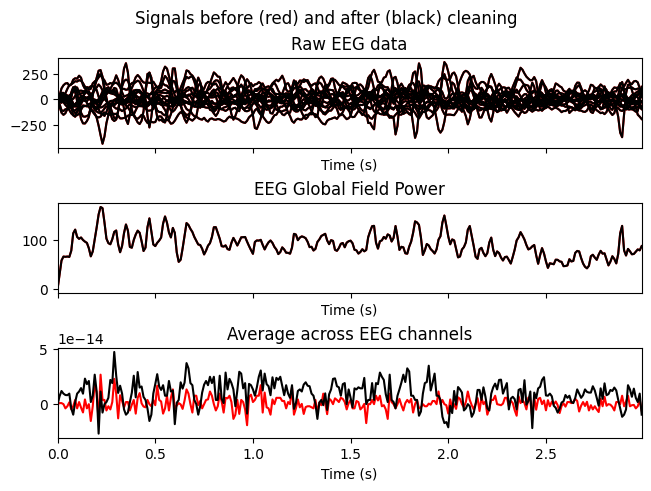

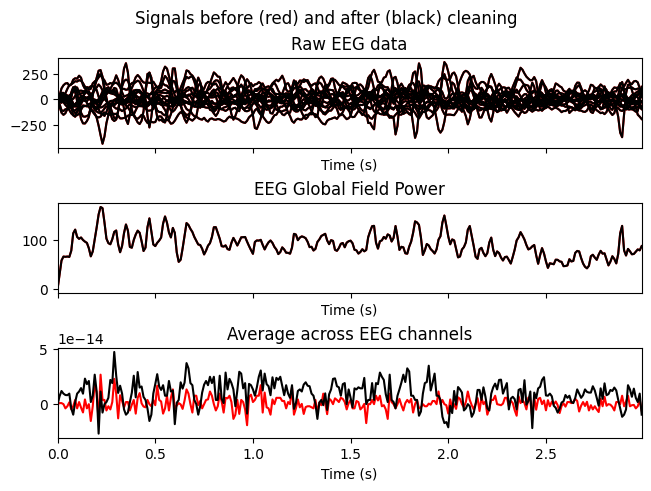

In [25]:
ica.plot_overlay(raw_wrapper.raws[0])

The channels chosen by ICA contain greater variability, indicating a usefulness for predictions.

#### Load to Tensorflow

In [26]:
raw_data = np.array([raw.get_data(return_times=False) for raw in raw_wrapper.raws]) # Get data from MNE objects
raw_labels = np.array(raw_wrapper.event_ids) # Get labels
print(f"Shape of raw_data: {raw_data.shape}")
print(f"Shape of raw_labels: {raw_labels.shape}")
data = (raw_data, raw_labels)

# Assert sizes of data still 600s
assert len(data[0]) == len(data[1])

Shape of raw_data: (36, 15, 60000)
Shape of raw_labels: (36,)


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((raw_data, raw_labels))
cardinality = len(dataset) # For use later

In [28]:
print(dataset.element_spec)

(TensorSpec(shape=(15, 60000), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


We currently have 600 second long features in our tensor dataset. In order to artificially increase the number of training samples, we will be splitting each sample into 100 different 6 second long samples and then shuffling them.

In [29]:
# split each 600s feature into 6 second windows
sfreq = 100
window_size = sfreq * 6
num_splits = (600 * sfreq) // window_size

def split_feature(feature, label):
    split_features = tf.split(value=feature, num_or_size_splits=num_splits, axis=1, name="feature")
    labels = tf.fill(dims=(num_splits,), value=label, name="label")
    w = tf.data.Dataset.from_tensor_slices((split_features, labels))
    return w
    
dataset = dataset.flat_map(lambda f, l: split_feature(f,l))

In [30]:
# Shuffle 
dataset = dataset.shuffle(buffer_size=900000) # Buffersize is 100 elements

In [31]:
# Error with cardinality due to flat_map
num_items = tf.data.experimental.cardinality(dataset).numpy()
print(f"Cardinality: {num_items} items")
# Assert cardinality since we know how the dataset changed
dataset = dataset.apply(tf.data.experimental.assert_cardinality(cardinality * num_splits))
print(f"After asserting cardinality: {len(dataset)} items")

Cardinality: -2 items
After asserting cardinality: 3600 items


#### Reshape Data
Features need to be in the form (batch_size, height, width, channels) for Conv2d. They are currently in shape (15, 600)
Labels need to be in the form (batch_size,). They are currently scalars.

In [32]:
def reshape_features(feature, label):
    # Reshape and recast
    feature = tf.reshape(feature, (-1, 15, 600, 1))
    feature = tf.cast(x=feature, dtype=tf.float32, name="feature")
    label = tf.reshape(label, (1,))
    label = tf.cast(x=label, dtype=tf.float32, name="label")
    return feature, label 


#dataset = dataset.map(reshape_features)
#dataset.element_spec

#### Create Feature Dataset

In [33]:
def create_features(f, l):
    feature_matrix = []
    for c in f:
        freqs, pows = welch(x=c, fs=100)
        features = [kurtosis(c),
                    skew(c),
                    np.std(c),
                    np.std(pows),
                    np.mean(pows),
                    entropy(pows)]
        feature_matrix.append(features)
        #print(len(feature_matrix[0]), len(feature_matrix))
    #print(np.array(feature_matrix).shape)
    return np.array(feature_matrix), l

def feature_generator():
    for f, l in dataset:
        yield create_features(f, l)


feature_dataset = tf.data.Dataset.from_generator(
    feature_generator,
    output_signature=(
        tf.TensorSpec(shape=(15, 6), dtype=tf.float64),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
)
print(feature_dataset.element_spec)

(TensorSpec(shape=(15, 6), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


#### Create Train and Test

In [34]:
"""train_len = int(0.7 * len(dataset))
test_len = int(0.2 * len(dataset))
val_len = int(0.1 * len(dataset))

train_dataset = dataset.take(train_len)
test_dataset = dataset.skip(train_len).take(test_len) 
val_dataset = dataset.skip(train_len).skip(test_len)

print(f"Train: {len(train_dataset)}")
print(f"Test: {len(test_dataset)}")
print(f"Val: {len(val_dataset)}")"""

get_labels = lambda f, l: l
get_features = lambda f, l: f
recast_labels = lambda l: tf.cast(x=l, dtype=tf.int32, name="label")
recast_features = lambda f: tf.cast(x=f, dtype=tf.float32, name="feature")

y_data  = dataset.map(get_labels)
X_data = dataset.map(get_features) 

y_data = y_data.map(recast_labels)
X_data = X_data.map(recast_features)

y_data = np.array(list(y_data.as_numpy_iterator()))
X_data = np.array(list(X_data.as_numpy_iterator()))

print(X_data.shape)
print(y_data.shape)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size=0.2, 
                                                    stratify=y_data)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

(3600, 15, 600)
(3600,)
X_train shape: (2880, 15, 600)
X_test shape: (720, 15, 600)
y_train shape: (2880,)
y_test shape: (720,)


In [35]:
y_data_f  = feature_dataset.map(get_labels)
X_data_f = feature_dataset.map(get_features) 

y_data_f = y_data_f.map(recast_labels)
X_data_f = X_data_f.map(recast_features)

y_data_f = np.array(list(y_data_f.as_numpy_iterator()))
X_data_f = np.array(list(X_data_f.as_numpy_iterator()))

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_data_f, y_data_f,
                                                    test_size=0.2, 
                                                    stratify=y_data_f)

In [36]:
print(f"X_train_f shape: {X_train_f.shape}")
print(f"X_test_f shape: {X_test_f.shape}")
print(f"y_train_f shape: {y_train_f.shape}")
print(f"y_test_f shape: {y_test_f.shape}")

X_train_f shape: (2880, 15, 6)
X_test_f shape: (720, 15, 6)
y_train_f shape: (2880,)
y_test_f shape: (720,)


We now have a training, testing, and validation dataset. Lets get on to predicting preictal events.

***
# Workspace
***

##### Protips

Organization:

> **Make sure your work is organized and "readable" to someone else:**
> * Organize your work using different text and code blocks
> * Use section subheaders (i.e. `##`, `###`, `####`, etc.) to format your text blocks
> * Wrap your code in functions for reuse in report
> * Document your work: either with code comments or text blocks (ideally both)



Model design:


> Different data problems require different architectures. For example,
>  * images/videos use CNNs
>  * sequential/temporal data uses RNNs
>  * game/action data uses DQNs
>
> Different data problems require different network sizes
> * Use at least 2 hidden layers (for deep-learning)
>    * *how many to use?* is data/problem dependent question
>
> Research your problem domain and make justifiable decisions. **You are expected to explain what you chose and why in your report.**

> If appropriate, consider an empirical comparison to a baseline/simple model
> * e.g., start with a simple `sklearn` classification/regression model and then move on to a `Tensorflow` Deep Learning model
> * This allows you to empiracally show how much better deep learning performs over more conventional models
> * note: this doesn't make sense for some data (e.g., images)

Ethics:

> * **DO** use web articles and APIs for ideas, tips, and guidance
> * **DO** read code examples from sources including TowardsDataScience, Stackoverflow, github
> * **DO** adapt ideas from your "inspired by" sources
> * **DO** cite any articles you used for inspiration or for technical help
>





> * **DON'T** need to cite common APIs (e.g., tensorflow, pandas)
> * **DON'T** just blindly recreate some web tutorial
> * **DON'T** cut and paste from the web
> * **DON'T** plagiarize (rather you should adapt and cite)

## Experiment(s)

For these experiments, we will be looking at the reccall score of our model. In the context of our task, recall tells how many seizures were predicted correctly compared to how many seizures were not predicted. The amount of seizures predicted as not a seizure is exceedingly important given that an epileptic patient would be relying on this prediction. 

### Support Vector Prediction

In [37]:
#X_train, X_test, y_train, y_test = [], [], [], []
# Train
#for f, l in train_dataset.as_numpy_iterator(): 
    #X_train.append(f)
    #y_train.append(l)
# Test
#for f, l in test_dataset.as_numpy_iterator(): 
    #X_test.append(f)
    #y_test.append(l)

In [38]:
# Reshape to be 2d
"""
X_train = np.array(X_train)
X_test = np.array(X_test)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

y_train = np.ravel(a=y_train)
y_test = np.ravel(a=y_test)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

print(f"X_train: {np.array(X_train).shape}") 
print(f"X_test: {np.array(X_test).shape}") 
print(f"y_train: {np.array(y_train).shape}") 
print(f"y_test: {np.array(y_test).shape}") 
"""

'\nX_train = np.array(X_train)\nX_test = np.array(X_test)\n\nX_train = X_train.reshape(X_train.shape[0], -1)\nX_test = X_test.reshape(X_test.shape[0], -1)\n\ny_train = np.ravel(a=y_train)\ny_test = np.ravel(a=y_test)\n\ny_train = y_train.astype(np.int32)\ny_test = y_test.astype(np.int32)\n\nprint(f"X_train: {np.array(X_train).shape}") \nprint(f"X_test: {np.array(X_test).shape}") \nprint(f"y_train: {np.array(y_train).shape}") \nprint(f"y_test: {np.array(y_test).shape}") \n'

In [158]:
param_grid = {"C":[0.1, 1], 
              "kernel": ["rbf", "poly", "sigmoid"]} 

X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
y_train_reshaped = np.ravel(a=y_train)
y_test_reshaped = np.ravel(a=y_test)

svc = SVC() 
grid_search = GridSearchCV(estimator=svc, scoring="recall", cv=3, param_grid=param_grid, n_jobs=-1) 

grid_search.fit(X=X_train_reshaped, y=y_train_reshaped)
print(f"Best train recall: {grid_search.best_score_ * 100 :.2f}") 

test_recall = grid_search.score(X=X_test_reshaped, y=y_test_reshaped)
print(f"Test recall: {test_recall * 100 :.2f}")

Best train recall: 67.15
Test recall: 98.33


| Model | Train Recall | Test Recall |
|----------|----------|----------|
| SVC  | 77.08%  | 57.22%|

In [159]:
X_train_f_reshaped = X_train_f.reshape(X_train_f.shape[0], -1)
X_test_f_reshaped = X_test_f.reshape(X_test_f.shape[0], -1)
y_train_f_reshaped = np.ravel(a=y_train_f)
y_test_f_reshaped = np.ravel(a=y_test_f)

svc = SVC() 
grid_search = GridSearchCV(estimator=svc, scoring="recall", cv=3, param_grid=param_grid, n_jobs=-1) 

grid_search.fit(X=X_train_f_reshaped, y=y_train_f_reshaped)
print(f"Best train recall: {grid_search.best_score_ * 100 :.2f}") 

test_f_recall = grid_search.score(X=X_test_f_reshaped, y=y_test_f_reshaped)
print(f"Test recall: {test_recall * 100 :.2f}")

Best train recall: 33.19
Test recall: 98.33


| Model | Train Recall | Test Recall |
|----------|----------|----------|
| SVC  | 77.08%  | 57.22%|

### Callbacks for Training Neural Net

In [41]:
recall_early_stop = EarlyStopping(monitor="val_recall", mode="max",
                                  patience=3, restore_best_weights=False)                                  

In [42]:
# This class wasn't used
if hasattr(tqdm, '_instances'): tqdm._instances.clear()
class TQDMCallBack(tf.keras.callbacks.Callback):
    def __init__(self):
        super(TQDMCallBack, self).__init__()

    def on_epoch_begin(self, epoch, logs=None):
        self.pbar = tqdm(desc=f"loss: {logs['recall']}")
    
    def on_epoch_end(self, logs = None): 
        self.pbar.close()

#### Dataset Again

In [66]:
X_train_expanded = np.expand_dims(X_train, axis=-1)
X_test_expanded = np.expand_dims(X_test, axis=-1)

X_train_f_expanded = np.expand_dims(X_train_f, axis=-1)
X_test_f_expanded = np.expand_dims(X_test_f, axis=-1)

print(X_train_expanded.shape) 
print(X_test_expanded.shape)
print(X_train_f_expanded.shape)
print(X_test_f_expanded.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_expanded, y_train)) 
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_expanded, y_test)) 

train_dataset = train_dataset.map(lambda f,l: (tf.reshape(f, (-1, 15, 600, 1)), tf.reshape(l, (1,))))
test_dataset = test_dataset.map(lambda f,l: (tf.reshape(f, (-1, 15, 600, 1)), tf.reshape(l, (1,))))

train_len = int(0.8 * len(train_dataset))
val_dataset = train_dataset.skip(train_len) 
train_dataset = train_dataset.take(train_len)

train_f_dataset = tf.data.Dataset.from_tensor_slices((X_train_f_expanded, y_train)) 
test_f_dataset = tf.data.Dataset.from_tensor_slices((X_test_f_expanded, y_test)) 

train_f_dataset = train_f_dataset.map(lambda f,l: (tf.reshape(f, (-1, 15, 6, 1)), tf.reshape(l, (1,))))
test_f_dataset = test_f_dataset.map(lambda f,l: (tf.reshape(f, (-1, 15, 6, 1)), tf.reshape(l, (1,))))


train_len = int(0.8 * len(train_f_dataset))
val_f_dataset = train_f_dataset.skip(train_len) 
train_f_dataset = train_f_dataset.take(train_len)

print(train_f_dataset.element_spec)
print(train_dataset.element_spec)

for f, l in train_dataset.take(1): 
    print(f.shape) 
    print(l.shape) 

(2880, 15, 600, 1)
(720, 15, 600, 1)
(2880, 15, 6, 1)
(720, 15, 6, 1)
(TensorSpec(shape=(1, 15, 6, 1), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None))
(TensorSpec(shape=(1, 15, 600, 1), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None))
(1, 15, 600, 1)
(1,)


## Models - Time Sequence

In [107]:
# Hyperparameters
batch_size = 128
n_epochs = 100
loss = tf.keras.losses.BinaryCrossentropy()
recall = Recall(name="recall")
acc = BinaryAccuracy(name="acc")
auc = AUC(name="auc")
metrics = [recall, acc, auc]
input_shape = (batch_size, 15, 600, 1) # (batch_size, height, width, channels)
tf.random.set_seed(1)

learning_rate = 5e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) 

### Basic Model

In [108]:
def make_cnn_classifier_basic(n_filters=8):
    Conv2D = partial(tf.keras.layers.Conv2D, padding='same', activation='relu', dtype=tf.float32)
    Dropout = partial(tf.keras.layers.Dropout, dtype=tf.float32)
    BatchNormalization = partial(tf.keras.layers.BatchNormalization, dtype=tf.float32)
    
    
    model = Sequential([
        Conv2D(filters=2*n_filters, kernel_size=(1, 20), strides=10, input_shape=input_shape[1:]), 
        BatchNormalization(), 

        Flatten(),
        Dense(1, activation="sigmoid")])
    return model

model_basic = make_cnn_classifier_basic()
model_basic.compile(optimizer=optimizer, loss=loss, metrics=metrics)
print(model_basic.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 2, 60, 16)         336       
                                                                 
 batch_normalization_49 (Bat  (None, 2, 60, 16)        64        
 chNormalization)                                                
                                                                 
 flatten_13 (Flatten)        (None, 1920)              0         
                                                                 
 dense_25 (Dense)            (None, 1)                 1921      
                                                                 
Total params: 2,321
Trainable params: 2,289
Non-trainable params: 32
_________________________________________________________________
None


#### Basic Model Training

In [109]:
history_basic_model = model_basic.fit(x=train_dataset, batch_size=batch_size, epochs=n_epochs,
                                      validation_data=val_dataset, shuffle=True, callbacks=[recall_early_stop])
clear_output()

In [ ]:
val_recall = history_basic_model.history["val_recall"]

print(f"STD val_recall: {np.std(val_recall) * 100 :.2f}")
print(f"Mean val_recall: {np.mean(val_recall) * 100 :.2f}")

#### Basic Model Testing

In [ ]:
model_basic.save("/home/matthewo/Documents/Projects/lab5/model_basic.h5")

In [49]:
def get_mean_recalls(model):
    recalls = []
    for i in range(5):
        history_basic_model = model.fit(x=train_dataset, batch_size=batch_size, epochs=n_epochs,
                                      validation_data=val_dataset, shuffle=True, callbacks=[recall_early_stop])
        l, recall, a, a = model.evaluate(test_dataset)
        recalls.append(recall)
    clear_output()
    return np.mean(recalls)

In [ ]:
print(f"Mean recall: {get_mean_recalls(model_basic) :.4f}")

In [110]:
basic_test_loss, basic_test_recall, basic_test_acc, basic_test_auc = model_basic.evaluate(test_dataset)

720/720 [==============================] - 1s 869us/step - loss: 1.3246 - recall: 0.5861 - acc: 0.4958 - auc: 0.4895


| Learning Rate | mean recall | 
|---------------|--------|
| 5e-2        |   0.2844 |
| 5e-4           | 0.4422   |
| 5e-6           | 0.6250   |

### Time-Wise Model

In [155]:
learning_rate = 5e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) 

In [77]:
def make_cnn_classifier_timewise(n_filters=8):
    Conv2D = partial(tf.keras.layers.Conv2D, padding='same', activation='relu', dtype=tf.float32)
    Dropout = partial(tf.keras.layers.Dropout, dtype=tf.float32)
    BatchNormalization = partial(tf.keras.layers.BatchNormalization, dtype=tf.float32)
    
    
    model = tf.keras.Sequential([
        Conv2D(filters=2*n_filters, kernel_size=(1, 20), strides=10, input_shape=input_shape[1:]), 
        Dropout(0.2),
        BatchNormalization(), 

        Conv2D(filters=2*n_filters, kernel_size=(1, 10), strides=5), 
        Dropout(0.2),
        BatchNormalization(),

        Conv2D(filters=2*n_filters, kernel_size=(1, 10), strides=5),
        Dropout(0.2),
        BatchNormalization(),
        
        Conv2D(filters=4*n_filters, kernel_size=(1, 10), strides=2),
        Dropout(0.2),
        BatchNormalization(),

        Flatten(),
        Dense(20),
        Dropout(0.5),
        Dense(1, activation="sigmoid")])
    return model

model_timewise = make_cnn_classifier_timewise()
model_timewise.compile(optimizer=optimizer, loss=loss, metrics=metrics)
print(model_timewise.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 2, 60, 16)         336       
                                                                 
 dropout_16 (Dropout)        (None, 2, 60, 16)         0         
                                                                 
 batch_normalization_16 (Bat  (None, 2, 60, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 1, 12, 16)         2576      
                                                                 
 dropout_17 (Dropout)        (None, 1, 12, 16)         0         
                                                                 
 batch_normalization_17 (Bat  (None, 1, 12, 16)        64        
 chNormalization)                                     

#### Timewise Model Training

In [78]:
mean_recall = get_mean_recalls(model_timewise)
clear_output()
print(f"Mean recall: {mean_recall :.4f}")

Mean recall: 0.6472


In [156]:
history_timewise_model = model_timewise.fit(x=train_dataset, batch_size=batch_size, epochs=n_epochs,
                                            validation_data=val_dataset, shuffle=True, callbacks=[recall_early_stop])
clear_output()

In [157]:
timewise_test_loss, timewise_test_recall, timewise_test_acc, timewise_test_auc = model_timewise.evaluate(test_dataset)

720/720 [==============================] - 1s 1ms/step - loss: 0.6923 - recall: 0.7778 - acc: 0.4931 - auc: 0.4990


| Learning Rate | recall |
|---------------|--------|
| 5e-2          |   0.4222     | 
| 5e-4           |   0.6472  |  
| 5e-6           |  0.6300  | 

### Channel-Wise Model

In [86]:
learning_rate = 5e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) 

In [87]:
def make_cnn_classifier_channelwise(n_filters=8):
    Conv2D = partial(tf.keras.layers.Conv2D, padding='same', activation='relu', dtype=tf.float32)
    Dropout = partial(tf.keras.layers.Dropout, dtype=tf.float32)
    BatchNormalization = partial(tf.keras.layers.BatchNormalization, dtype=tf.float32)
    
    
    model = tf.keras.Sequential([
        Conv2D(filters=2*n_filters, kernel_size=(5, 20), strides=10, input_shape=input_shape[1:]), 
        Dropout(rate=0.2), 
        BatchNormalization(), 

        Conv2D(filters=2*n_filters, kernel_size=(5, 5), strides=5), 
        Dropout(rate=0.2), 
        BatchNormalization(),

        Conv2D(filters=2*n_filters, kernel_size=(5, 5), strides=5),
        Dropout(rate=0.2),
        BatchNormalization(),
        
        Conv2D(filters=4*n_filters, kernel_size=(5, 5), strides=5),
        Dropout(rate=0.2),
        BatchNormalization(),

        Flatten(),
        Dense(20),
        Dense(1, activation="sigmoid")])
    return model

model_channelwise = make_cnn_classifier_channelwise()
model_channelwise.compile(optimizer=optimizer, loss=loss, metrics=metrics)
print(model_channelwise.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 2, 60, 16)         1616      
                                                                 
 dropout_35 (Dropout)        (None, 2, 60, 16)         0         
                                                                 
 batch_normalization_32 (Bat  (None, 2, 60, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 1, 12, 16)         6416      
                                                                 
 dropout_36 (Dropout)        (None, 1, 12, 16)         0         
                                                                 
 batch_normalization_33 (Bat  (None, 1, 12, 16)        64        
 chNormalization)                                     

#### Channelwise

In [179]:
mean_recall = get_mean_recalls(model_channelwise)
clear_output()
print(f"Mean recall: {mean_recall :.4f}")

Mean recall: 0.0000


In [100]:
channelwise_test_loss, channelwise_test_recall, channelwise_test_acc, channelwise_test_auc = model_channelwise.evaluate(test_dataset)

720/720 [==============================] - 1s 1ms/step - loss: nan - recall: 0.0000e+00 - acc: 0.5000 - auc: 0.5000


In [ ]:
channelwise_history = model_channelwise.fit(x=train_dataset, batch_size=batch_size, epochs=n_epochs, validation_data=val_dataset, 
                      shuffle=True)

## Feature Matrix Model

In [136]:
learning_rate = 5e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) 
input_shape_f = input_shape = (batch_size, 15, 6, 1)

In [137]:
def make_cnn_classifier_features(n_filters=8):
    Conv2D = partial(tf.keras.layers.Conv2D, padding='same', activation='relu', dtype=tf.float32)
    Dropout = partial(tf.keras.layers.Dropout, dtype=tf.float32)
    BatchNormalization = partial(tf.keras.layers.BatchNormalization, dtype=tf.float32)
    
    
    model = tf.keras.Sequential([
        Conv2D(filters=1*n_filters, kernel_size=(3, 1), strides=1, input_shape=input_shape_f[1:]), 
        Dropout(0.2),
        BatchNormalization(), 

        Conv2D(filters=1*n_filters, kernel_size=(3, 1), strides=1), 
        Dropout(0.2),
        BatchNormalization(),

        Conv2D(filters=2*n_filters, kernel_size=(3, 1), strides=1),
        Dropout(0.2),
        BatchNormalization(),
        
        Conv2D(filters=4*n_filters, kernel_size=(3, 1), strides=1),
        Dropout(0.2),
        BatchNormalization(),

        Flatten(),
        Dense(20),
        Dense(1, activation="sigmoid")])
    return model

model_features = make_cnn_classifier_features()
model_features.compile(optimizer=optimizer, loss=loss, metrics=metrics)
print(model_features.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 15, 6, 8)          32        
                                                                 
 dropout_79 (Dropout)        (None, 15, 6, 8)          0         
                                                                 
 batch_normalization_70 (Bat  (None, 15, 6, 8)         32        
 chNormalization)                                                
                                                                 
 conv2d_71 (Conv2D)          (None, 15, 6, 8)          200       
                                                                 
 dropout_80 (Dropout)        (None, 15, 6, 8)          0         
                                                                 
 batch_normalization_71 (Bat  (None, 15, 6, 8)         32        
 chNormalization)                                    

In [95]:
def get_mean_recalls_f(model):
    recalls = []
    for i in range(5):
        history_basic_model = model.fit(x=train_f_dataset, batch_size=batch_size, epochs=n_epochs,
                                      validation_data=val_f_dataset, shuffle=True, callbacks=[recall_early_stop])
        l, recall, a, a = model.evaluate(test_f_dataset)
        recalls.append(recall)
    clear_output()
    return np.mean(recalls)

In [115]:
mean_recall = get_mean_recalls_f(model_features)
clear_output()
print(f"Mean recall: {mean_recall :.4f}")

Mean recall: 0.9994


In [140]:
history_features_model = model_features.fit(x=train_f_dataset, batch_size=batch_size, epochs=n_epochs,
                                            validation_data=val_f_dataset, shuffle=True, callbacks=[recall_early_stop])
clear_output()

In [141]:
features_test_loss, features_test_recall, features_test_acc, features_test_auc = model_features.evaluate(test_f_dataset)

720/720 [==============================] - 1s 1ms/step - loss: 0.6944 - recall: 0.9333 - acc: 0.4986 - auc: 0.4781


## Graphing

In [177]:
def barplot_scores(names, scores):
    plt.figure(figsize=(10,10))
    ax = sns.barplot(x=names, y=scores, palette="viridis", hue=names, legend=False)
    ax.set(ylabel="Recall", xlabel="Model", title="Recall Score for Models")
    plt.show() 

In [161]:
recall_names = ["svc", "svc_f","basic_nn", "timewise_nn", "channelwise_nn", "features_nn"]
recall_scores = [test_recall, test_f_recall, basic_test_recall, timewise_test_recall, channelwise_test_recall, features_test_recall]

***
# Report
***

## Report Functions

### Expectations

Write a research "paper" that summarizes your work.

Your report should include the following sections.

1. [Introduction](https://libguides.usc.edu/writingguide/introduction)
2. Dataset and Pre-processing
3. [Methods](https://libguides.usc.edu/writingguide/methodology) (Experiment)
4. [Results and Analysis](https://libguides.usc.edu/writingguide/results)
5. [Discussion](https://libguides.usc.edu/writingguide/discussion) and [Conclusion](https://libguides.usc.edu/writingguide/conclusion)
6. [References](https://libguides.usc.edu/writingguide/citingsources)

This should be a thorough, long and thoughtful paper. It should be able to stand alone and give a clear understanding of your process without needing to refer to code above.

##### Protips

> * Explain your problem statement, your data, your experimental design decisions, your results, and your analysis.
>   * assume an audience that is completely unfamiliar with your problem, but understands deep-learning.  
>
> * Use subheaders for your sections.
>
> * Some sections will be shorter (e.g. Intro) while others will be much longer (e.g. Methods or Results).
>
> * Justify your design choices.
>   * this could be shown empirically, drawn from external (cited) sourches, or given as explanations of your intuitions about the problem domain
>
> * Integrate your programmatic results (results, graphs, tables, etc.) within your report to support your prose.
>
> * *Results* section explains the "what" of your findings; *Discussion* explains the "why".
>
> * You do not need to "formally" (e.g., APA) cite your references.
>    * rather, provide a title, author (if given), and URL
>    * e.g., Dumane, G. [Introduction to Convolutional Neural Network (CNN) using Tensorflow](https://towardsdatascience.com/introduction-to-convolutional-neural-network-cnn-de73f69c5b83)

In [143]:
raw = RawWrapper(["/home/matthewo/Documents/Projects/lab5//Patient_1_preictal_segment_0001.mat"])

(15, 3000000)
Creating RawArray with float64 data, n_channels=15, n_times=3000000
    Range : 0 ... 2999999 =      0.000 ...   600.000 secs
Ready.


## Analysis of Neural Networks on Classifying Preictal Electroencephalography Sequences

### Introduction
#### Problem
Epilepsy is a chronic neurological disease that effects around 50 million people worldwide$^{[1]}$. Epilepsy, characterized by spontaneous seizures, cannot be removed completely in approximately 30% of epileptic patients $^{[1]}$. These individuals often experience anxiety due to the possibility of an unexpected seizure. Unexpected seizures can be fatal as normal activities such as driving or swimming turn fatal. This creates the need for high precision seizure detection systems which inform patients of upcoming seizures.

There are four phases of a seizure: interictal (baseline), preictal (preceding a seizure), ictal (seizure), and postictal (after seizure)$^{[2]}$. These four states can be identified in electroencephalogram (EEG) data.

In this lab, EEG data classification will be explored in several methods. Feature extraction will be an initial concern, as time-series EEG data may not be the best format to classify preictal states. Then, support vector classification will be tested as a method to classify EEG data into different states. Finally, a neural network will be built to classify preictal states in order to predict ictal states.

### Dataset
When choosing a dataset of electroencephalography (EEG) seizure events, there are a multitude of variables to consider. For one, the majority of the data in these datasets are during interictal periods. This creates problems for prediction algorithms which require large amounts of classified truth values. Another consideration is whether the EEG was recorded from electrodes placed on the scalp of the patient, or an intracranial implant where electrodes are placed directly on the brain. Intracranial EEGs (iEEG) contain less dropouts and noise compared to scalp EEGs, but involve an invasive procedure$^{[3]}$.

EEG datasets differ in the amount of electrode channels recorded. Each pair of electrodes creates a channel which represents the voltage difference between the electrodes. The choice of channels in datasets may limit the features of the data, or instead create unrealistic estimates that can't be recreated with real-world data. There are different type of seizures that each present differently on EEG recordings. Additionally, patient specific markers may be more predictive than generalized markers$^{[4]}$.

In this lab, EEG samples were taken from the "American Epilepsy Society Seizure Prediction Challenge". The EEG samples come in a ${(channels, time)}$ format, where 15 different voltage channels have ten minutes of readings.

#### Preprocessing

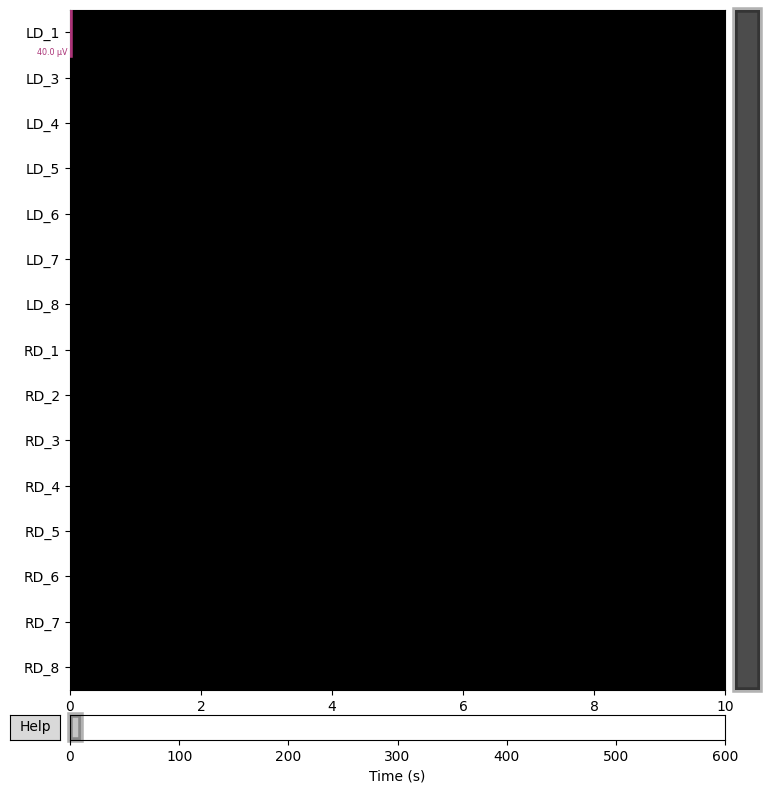

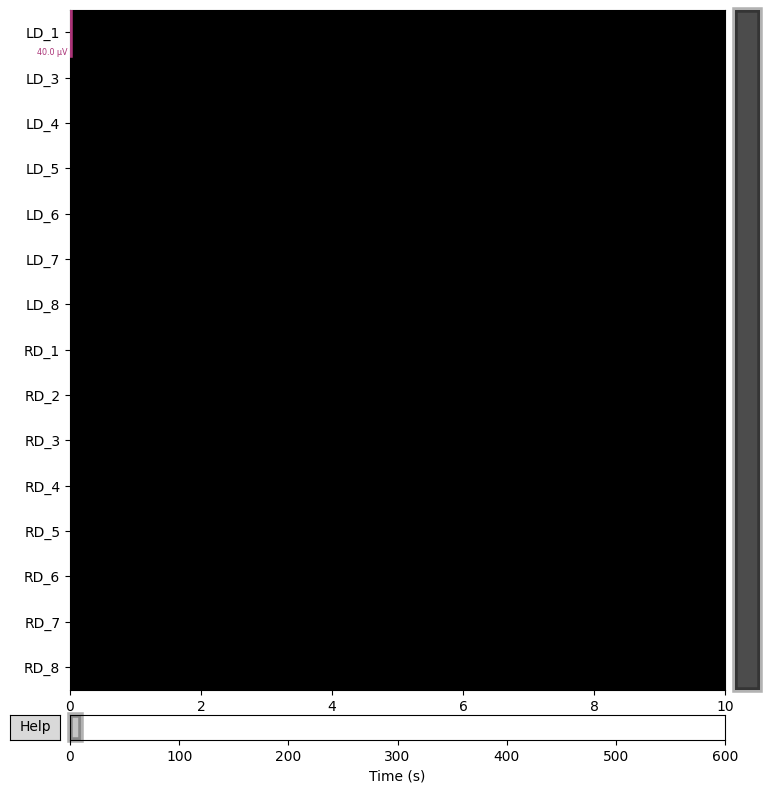

In [145]:
raw.raws[0].plot()

When I first loaded the dataset, I plotted the first preictal and interictal sample. I immediately noticed a massive amount of noise in the preictal sample. The voltage of each channel has such extreme values that the channels overlap when graphing. 

Initially, I though these fluctuating voltage values were indicative of an upcoming seizure. This though process guided my initial feature plannig. However, when I graphed the Power Spectral Density of this sample, I noticed a trend.

Effective window size : 0.410 (s)


/tmp/ipykernel_166439/974369650.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.raws[0].compute_psd().plot()
/usr/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


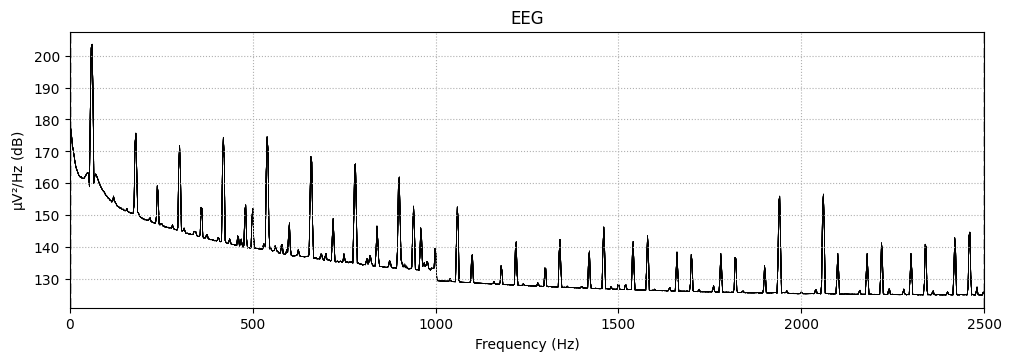

In [146]:
raw.raws[0].compute_psd().plot()

With the Power Spectral Density graphed, we can see an increase in power in the harmonics of 60hz. This is likely caused by the powerline interference phenomena, since powerlines in North American run at 60hz. 

While I could have attempted to filter out the harmonics of 60Hz with a notch filter, the other EEG samples don't have the same noise. In order to not alter the entire dataset based on one sample, I decided to find another method of removing noise from the data.

In addition to filtering out line noise, I wished to reduce the computational cost of my algorithm. This led to downsampling my data to 100 Hz, which would also prevent overfitting based on high frequency components. 

Before I downsampled my data, I first ran a highpass and lowpass filter on the data. The highpass filter was run at 0.1Hz in order to remove slow drifts and irrelevant noise. These slow drifts would inhibit my predictions since I decided to break up the 10 minute sequences into 6 second sequences. The lowpass filter stopped the data at 50Hz, the Nyquist frequency of 100Hz. This would both prevent aliasing during my downsampling process, and have the side effect of filtering out powerline interference.

Effective window size : 20.480 (s)


/tmp/ipykernel_166439/3079047713.py:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.raws[0].compute_psd().plot()
/usr/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


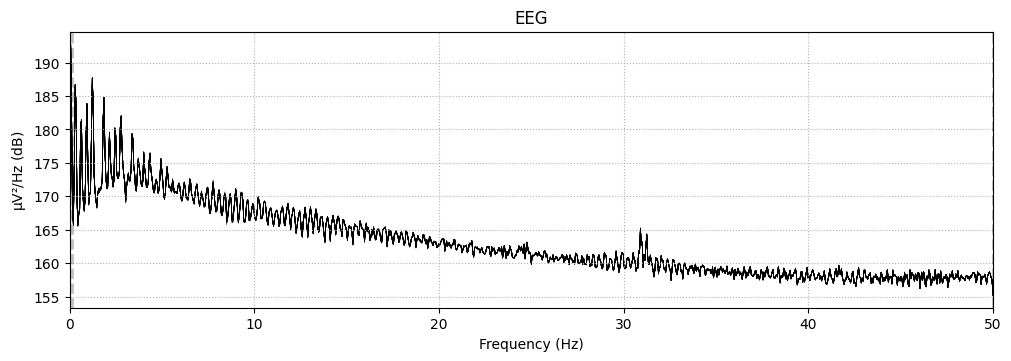

In [149]:
raw.filter(l_freq=0.1, h_freq=50)
raw.resample(sfreq=100)
clear_output()
raw.raws[0].compute_psd().plot()

After filtering and downsampling the sample, the noise is reduced. However, the channels are still overlapping. This suggests that, for this sample, the signals of each channel are dominated by exterior noise. In order to fix this, I recomputed the EEG reference of each sample using the Common Average Reference. The Common Average Reference technique involves taking the mean of all the channels and subtracting that from each individual channel.$^6$ This in part reduces the shared noise and averages the error rate among channels.

Effective window size : 20.480 (s)


/tmp/ipykernel_166439/3004705173.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.raws[0].compute_psd().plot()
/usr/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


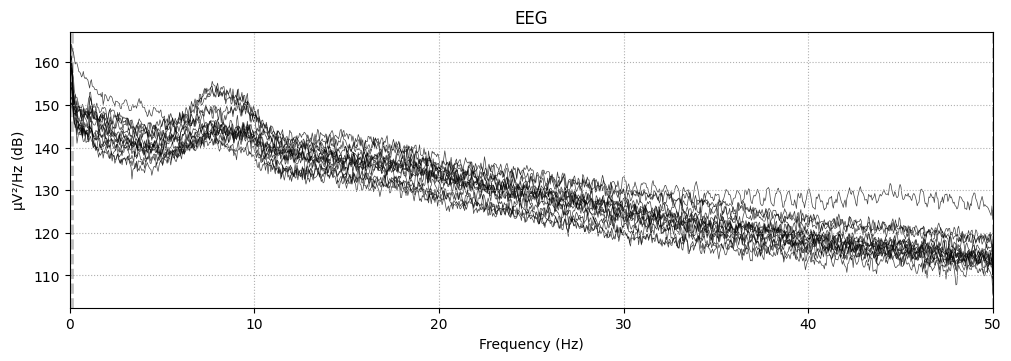

In [151]:
raw.set_eeg_reference()
clear_output()
raw.raws[0].compute_psd().plot()

Now, we can finally see power trends differing among the channels. This has introduced additional variation to the data, preparing it for use with predictive techniques.

## Experiment 
### Data Methodology

Data was prepared in two forms: time series in the shape $(15,600)$ and also features matrices derived from these time series. The information stored for each channel is below.

                    
| (Kurtosis) | (Skew) | (std voltage) | (std power) | (mean power) | (entropy power) |
|:--------:|:----:|:---:|:------------:|:-------------:|:----------------:|

These features attempt to grasp time-based changes in the data with skew and Kurtosis. Then, the standard deviation of both the voltage and power (power being the dependent variable arising from the power spectral density) identify variation caused by a preictal state. The entropy of the power attempts to address any disorder in the data.

A support Vector Classifier was grid searched on each of these datasets, providing a baseline for the neural networks to compare against.

### Layer Architecture

Then, three neural network models were created to run on the time sequence data. The architectures of these models are shown below:

#### Basic Model Architecture

| Basic Model Layers                                        |
|----------------------------------------------|
| Conv2D(24, (1, 20), 10) |
| BatchNormalization()                          | 
| Flatten()                                     | 
| Dense(1, "sigmoid")                |

The Basic Model has one Conv2d hidden node which convolves around the width of the timeseries. This forgoes any cross-channel features.

#### Time-Wise Model Architecture

| Time-Wise Model Layers                                        |
|----------------------------------------------|
| Conv2D(24,(1, 20), 10) |
| Dropout(0.2)                                 |
| BatchNormalization()                         |
|                                              |
| Conv2D(24, (1, 10), 5) |
| Dropout(0.2)                                 |
| BatchNormalization()                         |
|                                              |
| Conv2D(24, (1, 10), 5) |
| Dropout(0.2)                                 |
| BatchNormalization()                         |
|                                              |
| Conv2D(48, (1, 10), 2) |
| Dropout(0.2)                                 |
| BatchNormalization()                         |
|                                              |
| Flatten()                                    |
| Dense(20)                                    |
| Dropout(0.5)                                 |
| Dense(1, "sigmoid")               |

The Time-Wise model has four Conv2d nodes which convolve around the width of the time series. The number of filters increase as the nodes go on, and the lenght of the convolution decreases inversely. This allows the model to start with a broad feature search. In addition, dropout layers were added after each Conv2d node to prevent the model from overfitting. After the model was tested several times, increased performance was seen with lower learning rates. This led to an additional dropout node being placed directly before the final dense node.


#### Channel-Wise Model Architecture

| Channel-Wise Model Layers                                        |
|----------------------------------------------|
| Conv2D(24, (5, 20), 10) |
| Dropout(0.2)                            |
| BatchNormalization()                         |
|                                             |
| Conv2D(24, (5, 5), 5) |
| Dropout(0.2)                            |
| BatchNormalization()                         |
|                                             |
| Conv2D(24, (5, 5), 5) |
| Dropout(0.2)                            |
| BatchNormalization()                         |
|                                              |
| Conv2D(48, (5, 5), 5) |
| Dropout(0.2)                            |
| BatchNormalization()                         |
|                                              |
| Flatten()                                    |
| Dense(20)                                    |
| Dense(1, "sigmoid")               |


The Channel-Wise model has the same hidden node structure as the Time-Wise model, except the nodes attempt to convolve around both the channels and time series. This was an attempt to find features based on combinations of channels, however the Channel-Wise model performed exceptionally poorly.



#### Feature Matrix Model Architecture

In addition to the time series models, a feature matrix model was made for the engineered features.


| Feature Matrix Model Layers                                        |
|----------------------------------------------|
| Conv2D(12, (3, 1), 1) |
| Dropout(0.2)                                 |
| BatchNormalization()                         |
|                                              |
| Conv2D(12, (3, 1), 1) |
| Dropout(0.2)                                 |
| BatchNormalization()                         |
|                                              |
| Conv2D(24, (3, 1), 1) |
| Dropout(0.2)                                 |
| BatchNormalization()                         |
|                                              |
| Conv2D(48, (3, 1), 1) |
| Dropout(0.2)                                 |
| BatchNormalization()                         |
|                                              |
| Flatten()                                    |
| Dense(20)                                    |
| Dense(1, "sigmoid")               |

The feature matrix model includes the dropout layers after each convulotion node like the Time-Wise model, but lacks the final dropout layer since it caused poor testing scores. The convolution filters convolve around the channels, attempting to find between-channel features like the Channel-Wise model. 

### Methodology

Each of these models were fit and tested on the learning rates $5e-2$, $5e-4$, and $5e-6$. The Binary Cross Entropy was used as the loss function since there are only two labels: preictal or interictal. A batch size of $128$ was enough to increase the training speed without causing any memory issues. When training the models were given an early stop callback based on the recall score of the validation set. The models stopped training three epochs after the validation recall stopped improving. Instead of the best performing model, the last model was kept during training. This prevents a model from being kept that overfit the data.

## Results


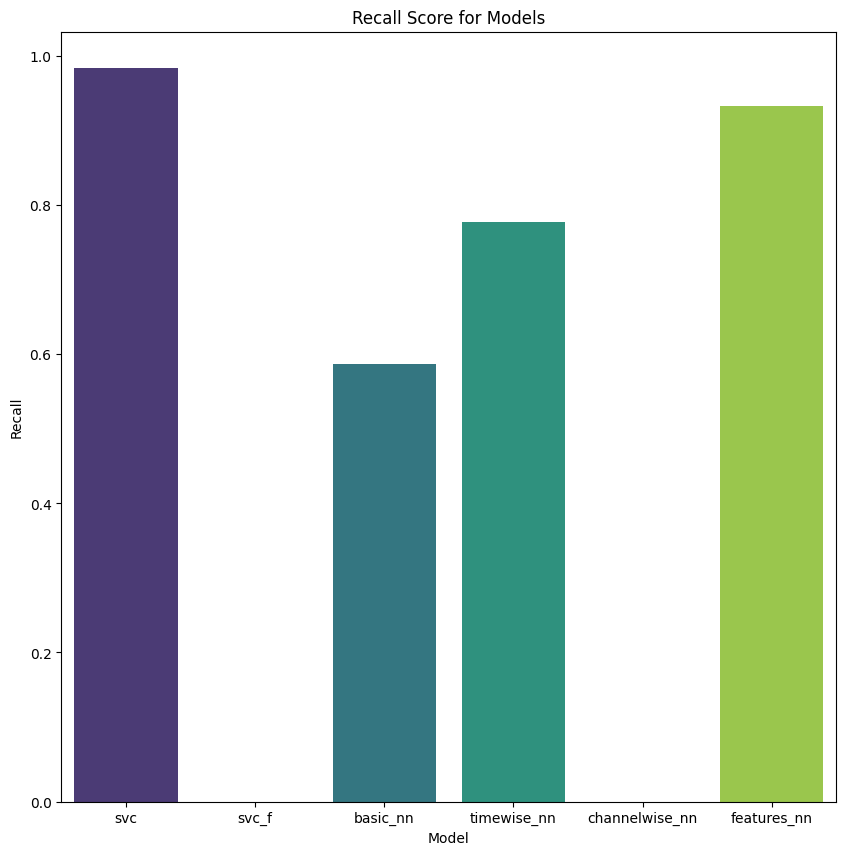

In [178]:
barplot_scores(recall_names, recall_scores)

The Support Vector Classifier outperformed all neural networks, achieving a recall rate of $97%$ on the flattened time sequences. The scores of both the Support Vector Classifier and the Features Neural Network show promise for utilization in predicting seizures. 

The high scores of the Feature Neural Network exhibit the importance of dimensionality reduction with certain data types. The initial time series were not conducive towards a prediction, so several statistical measures from both the time and spectral domains allow the model to grasp more from the data. This feature engineering prevents the model from needing to find features entirely itself.

Still, it is unknown how well these scores will hold up for larger datasets. The utilized dataset likely led to unrealistic scores since there were only 36 actual samples. This likely skewed results and made it more difficult for the neural networks to converge on an optimal solution. In addition, the testing dataset was preprocessed due to the awkward data structure it was in. 

The reason behind the null scores for the Feature Support Vector Classifier have not been explored yet. The most likely reason for the SVC's null score is an issue with the data shape of the features. However, it is 2-dimensional just the same as the other SVC. The data should be inspected in further detail. 

The Channel-Wise model returned null because the layers were setup incorrectly. The output shape of the first layer caused by a convolution around two axises returns an incompatable shape despite the padding being set as "same"

## Conclusion
Predicting seizures by classifying preictal seizure events is a challenging neurology problem. Steady classification of events requires electroencephalography to be preprocessed as well as feature engineered. Features in both time and spectral domains can be taken, allowing models to consider different frequency bands. This lab was inhibited by the quantity of data used, causing the samples to not be indicative of true samples. Further seizure prediction research should utilize feature engineering on a vast dataset.

***
# Works Cited
***
1. https://www.who.int/news-room/fact-sheets/detail/epilepsy
2. https://epilepsydisease.com/seizure-stages
3. https://academic.oup.com/book/35488
4. https://onlinelibrary.wiley.com/doi/10.1002/epi4.12704
5. https://www.kaggle.com/competitions/seizure-prediction/data
6. https://www.fieldtriptoolbox.org/faq/why_should_i_use_an_average_reference_for_eeg_source_reconstruction/
7. https://medium.com/nerd-for-tech/how-to-create-tensorflow-tfrecords-out-of-any-dataset-c64c3f98f4f8
